In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Необходимые библиотеки

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

# Настройка среды выполнения

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


# Загрузка и подготовка данных

Аугментация и нормализация данных

In [34]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((1000, 560)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((1000, 560)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

Загрузка данных

In [35]:
images_dir = "./drive/MyDrive/parse_dataset/img_classification/"
image_datasets = {x: datasets.ImageFolder(os.path.join(images_dir, x), data_transforms[x]) for x in ["train", "val"]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=8) for x in ["train", "val"]}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}

Классы изображений

In [36]:
class_names = image_datasets["train"].classes
print("Classes: {0}".format(class_names))

Classes: ['Йоруичи Шихоин', 'Ичиго Куросаки', 'Кенпачи Зараки', 'Кисуке Урахара', 'Сосуке Айзен']


Размеры выборок

In [37]:
print("Train size: {0}, Val size: {1}".format(dataset_sizes["train"], dataset_sizes["val"]))

Train size: 954, Val size: 50


Примеры изображений

In [46]:
def imshow(inp, title=None):
    """Отображение тензора как изображения с денормализацией"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Денормализация
    inp = np.clip(inp, 0, 1)

    plt.figure(figsize=(15, 10))
    plt.imshow(inp)

    if title is not None:
        # Объединяем заголовки через запятую и пробел
        plt.title(", ".join(title), pad=20, fontsize=12)  # <- Ключевое изменение здесь

    plt.axis('off')
    plt.tight_layout()
    plt.show()

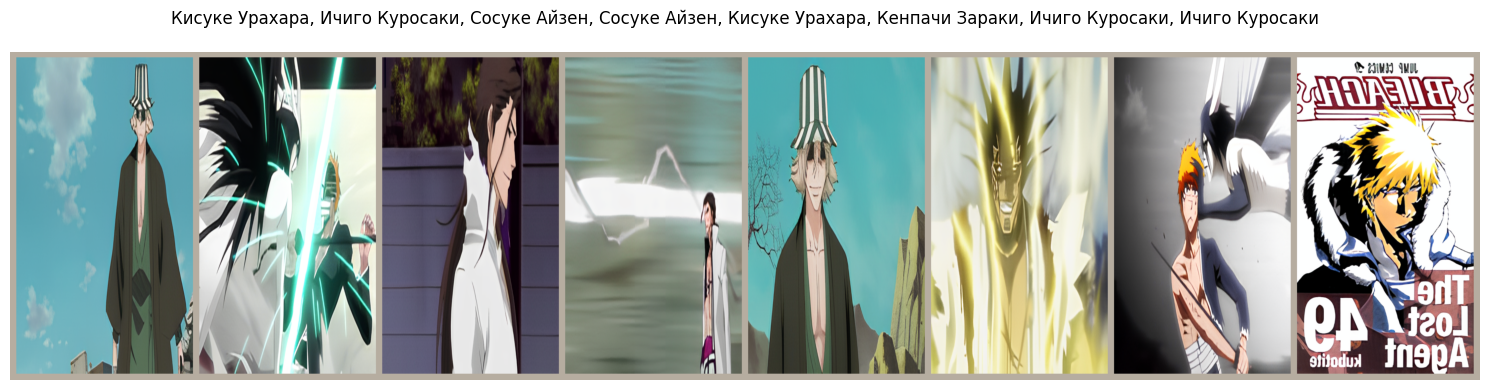

In [47]:
# Получаем батч изображений
inputs, classes = next(iter(dataloaders["train"]))

# Создаем сетку с отступами
out = torchvision.utils.make_grid(
    inputs,
    padding=20,
    pad_value=1.0  # Белый фон между изображениями
)

# Отображаем с заголовками в строку
imshow(out, title=[class_names[x] for x in classes])

# Загрузка предобученной модели и настройка её последнего слоя

In [48]:
def initialize_model(num_classes):
    """Инициализация предобученной модели ResNet18"""
    model = models.resnet18(pretrained=True)

    # Замораживаем все слои, кроме последнего
    for param in model.parameters():
        param.requires_grad = False

    # Заменяем последний полносвязный слой
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    model = model.to(device)

    return model

In [49]:
model = initialize_model(len(class_names))

# Обучение модели

Обучение модели

In [50]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Каждая эпоха имеет фазы обучения и валидации
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Режим обучения
            else:
                model.eval()   # Режим оценки

            running_loss = 0.0
            running_corrects = 0

            # Итерация по данным
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Обнуляем градиенты
                optimizer.zero_grad()

                # Прямой проход
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Обратный проход + оптимизация только в фазе обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Статистика
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Глубокое копирование модели, если точность улучшилась
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Загружаем веса лучшей модели
    model.load_state_dict(best_model_wts)
    return model

In [51]:
## Настройка параметров обучения
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## Обучение модели
model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 1.5315 Acc: 0.3711
val Loss: 1.3288 Acc: 0.4200

Epoch 2/10
----------
train Loss: 1.2951 Acc: 0.4937
val Loss: 1.1385 Acc: 0.5000

Epoch 3/10
----------
train Loss: 1.1529 Acc: 0.5660
val Loss: 1.1732 Acc: 0.5600

Epoch 4/10
----------
train Loss: 1.1361 Acc: 0.5304
val Loss: 0.9319 Acc: 0.5800

Epoch 5/10
----------
train Loss: 1.0584 Acc: 0.5922
val Loss: 0.8103 Acc: 0.7800

Epoch 6/10
----------
train Loss: 1.0602 Acc: 0.5818
val Loss: 0.7593 Acc: 0.8200

Epoch 7/10
----------
train Loss: 1.0599 Acc: 0.5755
val Loss: 0.7188 Acc: 0.8600

Epoch 8/10
----------
train Loss: 0.9211 Acc: 0.6719
val Loss: 0.7212 Acc: 0.8200

Epoch 9/10
----------
train Loss: 0.9151 Acc: 0.6740
val Loss: 0.6825 Acc: 0.8400

Epoch 10/10
----------
train Loss: 0.9264 Acc: 0.6583
val Loss: 0.7402 Acc: 0.6800

Training complete in 5m 21s
Best val Acc: 0.860000


Сохранение модели

In [52]:
torch.save(model.state_dict(), 'model_weights.pth')

# Визуализация результатов модели

Функция визуализации результатов

In [56]:
def visualize_model(model):
    num_images = 8
    images_so_far = 0

    model.eval()


    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(0, inputs.size()[0] - 1, 2):
                images_so_far += 1

                img1 = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img2 = inputs.cpu().data[j + 1].numpy().transpose((1, 2, 0))

                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])

                img1 = std * img1 + mean  # отмена нормализации
                img1 = np.clip(img1, 0, 1)  # ограничиваем значения [0, 1]

                img2 = std * img2 + mean  # отмена нормализации
                img2 = np.clip(img2, 0, 1)  # ограничиваем значения [0, 1]

                fig, axes = plt.subplots(1, 2, figsize=(10, 5))

                # Отображение изображений
                axes[0].imshow(img1)
                axes[0].axis("off")  # Отключение осей
                axes[0].set_title(class_names[preds[j]])

                axes[1].imshow(img2)
                axes[1].axis("off")
                axes[1].set_title(class_names[preds[j + 1]])

                plt.tight_layout()  # Автоматическая подгонка расстояний
                plt.show()

                if images_so_far == num_images:
                    return

Загрузка модели

In [57]:
%%capture
model = initialize_model(len(class_names))
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

Запуск визуализации

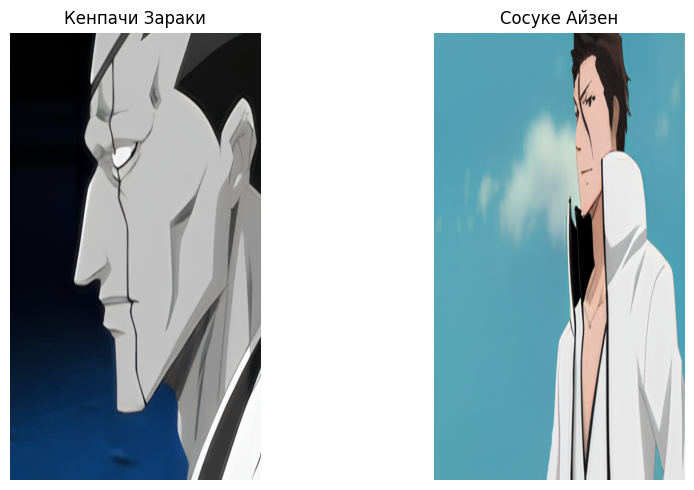

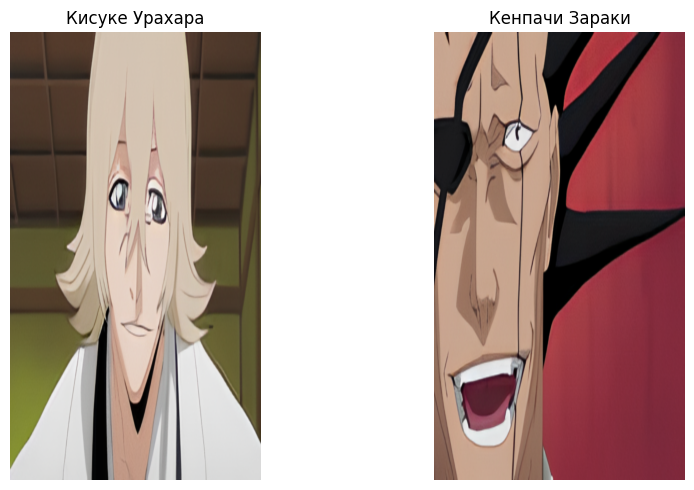

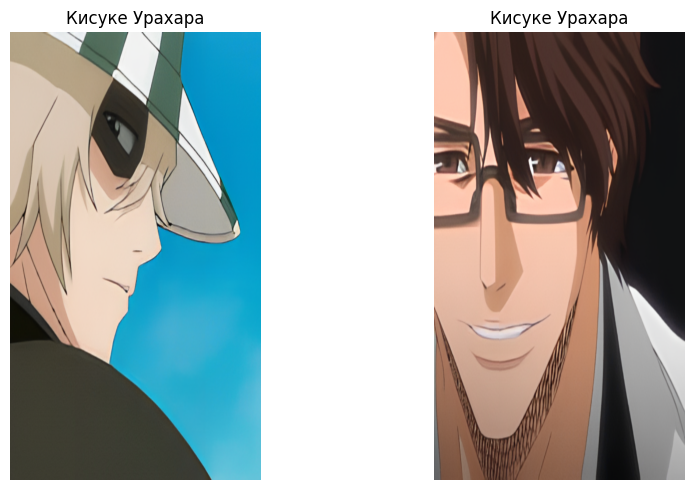

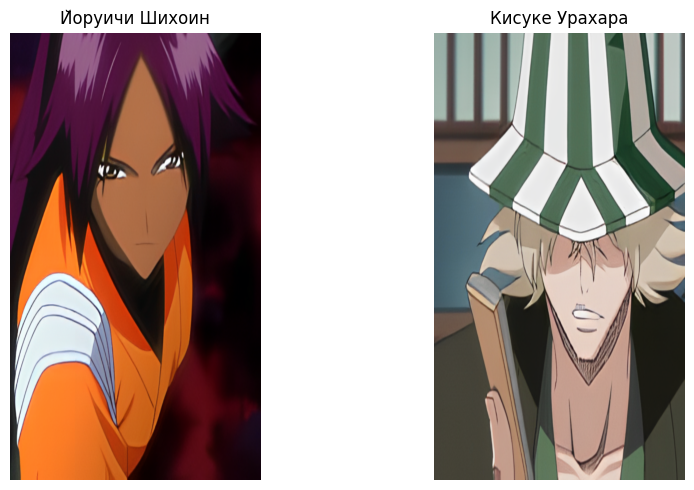

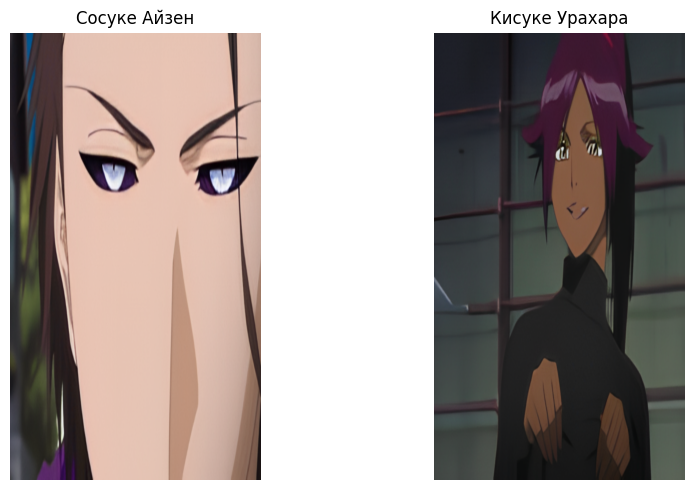

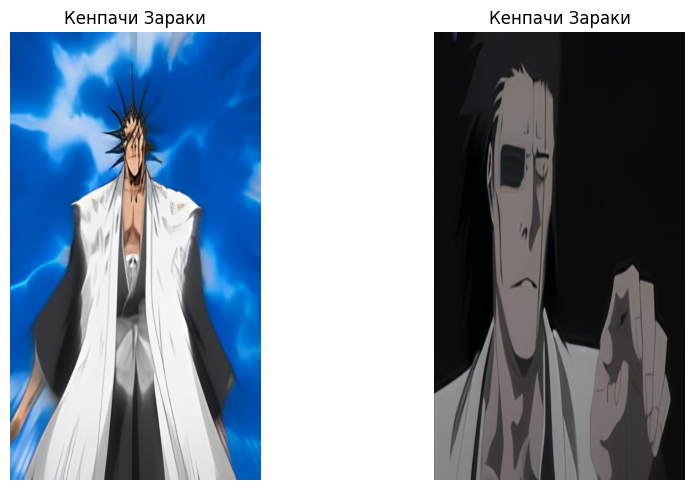

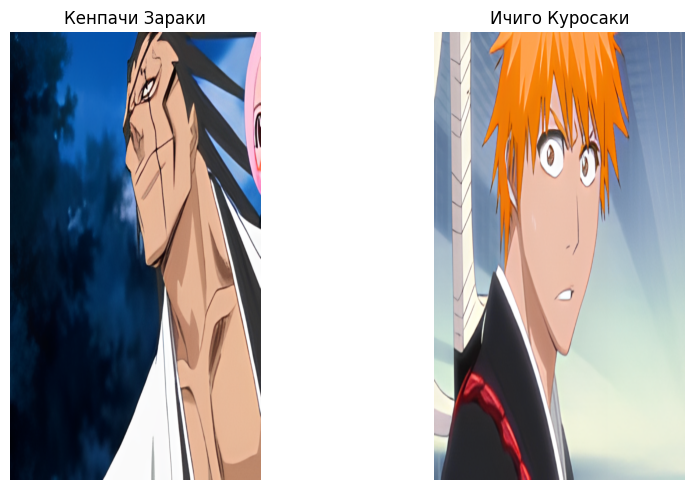

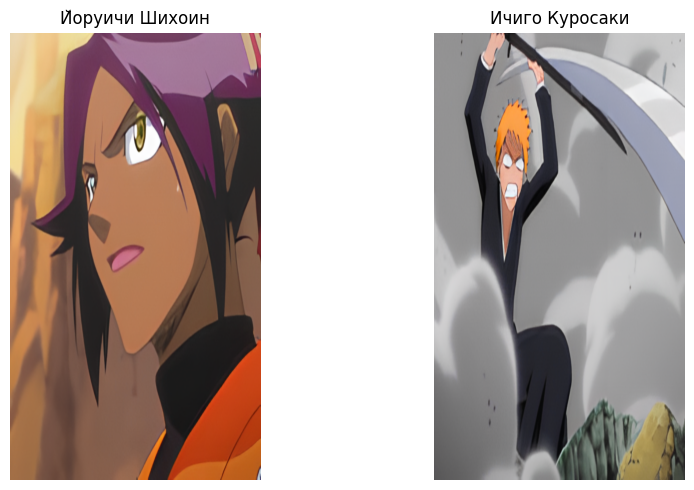

In [58]:
visualize_model(model)